# 作家风格识别

<br>
<hr>

# 1.实验介绍

## 1.1实验背景

作家风格是作家在作品中表现出来的独特的审美风貌。  
通过分析作品的写作风格来识别作者这一研究有很多应用，比如可以帮助人们鉴定某些存在争议的文学作品的作者、判断文章是否剽窃他人作品等。  
作者识别其实就是一个文本分类的过程，文本分类就是在给定的分类体系下，根据文本的内容自动地确定文本所关联的类别。
写作风格学就是通过统计的方法来分析作者的写作风格，作者的写作风格是其在语言文字表达活动中的个人言语特征，是人格在语言活动中的某种体现。



## 1.2 实验要求
a）建立深度神经网络模型，对一段文本信息进行检测识别出该文本对应的作者。   
b）绘制深度神经网络模型图、绘制并分析学习曲线。  
c）用准确率等指标对模型进行评估。    



## 1.3 实验环境
可以使用基于 Python 分词库进行文本分词处理，使用 Numpy 库进行相关数值运算，使用 Keras 等框架建立深度学习模型等。



## 1.4 注意事项
+ Python 与 Python Package 的使用方式，可在右侧 `API文档` 中查阅。
+ 当右上角的『Python 3』长时间指示为运行中的时候，造成代码无法执行时，可以重新启动 Kernel 解决（左上角『Kernel』-『Restart Kernel』）。



## 1.5 参考资料
jieba：https://github.com/fxsjy/jieba   
Numpy：https://www.numpy.org/  
Pytorch: https://pytorch.org/docs/stable/index.html  
TorchText: https://torchtext.readthedocs.io/en/latest/

# 2.实验内容

## 2.1 介绍数据集

该数据集包含了 8438 个经典中国文学作品片段，对应文件分别以作家姓名的首字母大写命名。  
数据集中的作品片段分别取自 5 位作家的经典作品，分别是：

|序号|中文名|英文名|文本片段个数|
|--|--|--|--|
|1|鲁迅|LX| 1500 条 |
|2|莫言|MY| 2219 条 |
|3|钱钟书|QZS| 1419 条 |
|4|王小波|WXB| 1300 条 |
|5|张爱玲|ZAL| 2000 条 |

+ 其中截取的片段长度在 100~200 个中文字符不等
+ 数据集路径为 `dataset/` 以作者名字首字母缩写命名



In [1]:
# 导入相关包
import copy
import os
import random
import numpy as np
import jieba as jb
import jieba.analyse
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as f
from torchtext import data
from torchtext import datasets
from torchtext.data import Field
from torchtext.data import Dataset
from torchtext.data import Iterator
from torchtext.data import Example
from torchtext.data import BucketIterator

读取数据集，保存在字典中

In [2]:
dataset = {}
path = "dataset/"
files= os.listdir(path)
for file in files:
    if not os.path.isdir(file) and not file[0] == '.': # 跳过隐藏文件和文件夹
        f = open(path+"/"+file, 'r',  encoding='UTF-8'); # 打开文件
        for line in f.readlines():
            dataset[line] = file[:-4]

数据集总共有 8438 个文本片段，现在展示其中的 6 个片段及其作者。

In [3]:
name_zh = {'LX': '鲁迅', 'MY':'莫言' , 'QZS':'钱钟书' ,'WXB':'王小波' ,'ZAL':'张爱玲'} 
for (k,v) in  list(dataset.items())[:6]:
    print(k,'---',name_zh[v])

几个少年辛苦奔走了十多年，暗地里一颗弹丸要了他的性命；几个少年一击不中，在监牢里身受一个多月的苦刑；几个少年怀着远志，忽然踪影全无，连尸首也不知那里去了。——“他们都在社会的冷笑恶骂迫害倾陷里过了一生；现在他们的坟墓也早在忘却里渐渐平塌下去了。
 --- 鲁迅
是的，你不解的。他一面点灯，一面冷静地说，“你的和我交往，我想，还正因为那时的哭哩。你不知道，这祖母，是我父亲的继母；他的生母，他三岁时候就死去了。他想着，默默地喝酒，吃完了一个熏鱼头。“那些往事，我原是不知道的。
 --- 鲁迅
这声音虽然极低，却很耳熟。看时又全没有人。站起来向外一望，那孔乙己便在柜台下对了门槛坐着。他脸上黑而且瘦，已经不成样子；穿一件破夹袄，盘着两腿，下面垫一个蒲包，用草绳在肩上挂住；见了我，又说道，“温一碗酒。
 --- 鲁迅
“阿，——纬甫，是你么？我万想不到会在这里遇见你。“阿阿，是你？我就邀他同坐，但他似乎略略踌躇之后，方才坐下来。我起先很以为奇，接着便有些悲伤，而且不快了。细看他相貌，也还是乱蓬蓬的须发；苍白的长方脸，然而衰瘦了。
 --- 鲁迅
我惶恐着，站起来说。“那么，我对你说。迅哥儿，你阔了，搬动又笨重，你还要什么这些破烂木器，让我拿去罢。我们小户人家，用得着。“我并没有阔哩。“阿呀呀，你放了道台⑼了，还说不阔？你现在有三房姨太太；出门便是八抬的大轿，还说不阔？
 --- 鲁迅
老三多两个孩子上学，老五也说他多用了公众的钱，气不过……。“这真是愈加闹不清了！月生失望似的说。“所以看见你们弟兄，沛君，我真是‘五体投地’。是的，我敢说，这决不是当面恭维的话。沛君不开口，望见听差的送进一件公文来，便迎上去接在手里。
 --- 鲁迅


## 2.2 数据集预处理  
在做文本挖掘的时候，首先要做的预处理就是分词。  
英文单词天然有空格隔开容易按照空格分词，但是也有时候需要把多个单词做为一个分词，比如一些名词如 "New York" ，需要做为一个词看待。  
而中文由于没有空格，分词就是一个需要专门去解决的问题了。  
这里我们使用 jieba 包进行分词，使用**精确模式**、**全模式**和**搜索引擎模式**进行分词对比。  
更多方法参考：https://github.com/fxsjy/jieba   

In [4]:
# 精确模式分词
titles = [".".join(jb.cut(t, cut_all=False)) for t,_ in dataset.items()]
print("精确模式分词结果:\n",titles[0])

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.813 seconds.
Prefix dict has been built successfully.


精确模式分词结果:
 几个.少年.辛苦.奔走.了.十多年.，.暗地里.一颗.弹丸.要.了.他.的.性命.；.几个.少年.一击.不.中.，.在.监牢.里.身受.一个多月.的.苦刑.；.几个.少年.怀着.远志.，.忽然.踪影.全无.，.连.尸首.也.不知.那里.去.了.。.—.—.“.他们.都.在.社会.的.冷笑.恶骂.迫害.倾陷.里.过.了.一生.；.现在.他们.的.坟墓.也.早.在.忘却.里.渐渐.平.塌下去.了.。.



In [5]:
# 全模式分词
titles = [".".join(jb.cut(t, cut_all=True)) for t,_ in dataset.items()]
print("全模式分词结果:\n",titles[0])

全模式分词结果:
 几个.少年.辛苦.奔走.了.十多.十多年.多年.，.暗地.暗地里.地里.一颗.弹丸.要.了.他.的.性命.；.几个.少年.一.击.不中.，.在.监牢.里.身受.一个.一个多.一个多月.多月.的.苦刑.；.几个.少年.怀着.远志.，.忽然.踪影.全.无.，.连.尸首.也.不知.那里.去.了.。——“.他们.都.在.社会.的.冷笑.恶骂.迫害.倾陷.里.过.了.一生.；.现在.他们.的.坟墓.也.早在.忘却.里.渐渐.平.塌下.塌下去.下去.了.。.
.


In [6]:
# 搜索引擎模式分词
titles = [".".join(jb.cut_for_search(t)) for t,_ in dataset.items()]
print("搜索引擎模式分词结果:\n",titles[0])

搜索引擎模式分词结果:
 几个.少年.辛苦.奔走.了.十多.多年.十多年.，.暗地.地里.暗地里.一颗.弹丸.要.了.他.的.性命.；.几个.少年.一击.不.中.，.在.监牢.里.身受.一个.多月.一个多.一个多月.的.苦刑.；.几个.少年.怀着.远志.，.忽然.踪影.全无.，.连.尸首.也.不知.那里.去.了.。.—.—.“.他们.都.在.社会.的.冷笑.恶骂.迫害.倾陷.里.过.了.一生.；.现在.他们.的.坟墓.也.早.在.忘却.里.渐渐.平.塌下.下去.塌下去.了.。.



**使用 TF-IDF 算法统计各个作品的关键词频率**                                                                 
TF-IDF（term frequency–inverse document frequency，词频-逆向文件频率）是一种用于信息检索与文本挖掘的常用加权技术。  
* TF-IDF是一种统计方法，用以评估一字词对于一个文件集或一个语料库中的其中一份文件的重要程度。               
字词的重要性随着它在文件中出现的次数成正比增加，但同时会随着它在语料库中出现的频率成反比下降。  
* TF-IDF的主要思想是：如果某个单词在一篇文章中出现的频率TF高，并且在其他文章中很少出现，则认为此词或者短语具有很好的类别区分能力，适合用来分类。  
这里我们使用 jieba 中的默认语料库来进行关键词抽取，并展示每位作者前 5 个关键词


In [7]:
# 将片段进行词频统计
str_full = {}
str_full['LX'] = ""
str_full['MY'] = ""
str_full['QZS'] = ""
str_full['WXB'] = ""
str_full['ZAL'] = ""

for (k,v) in dataset.items():
    str_full[v] += k

for (k,v) in str_full.items():
    print(k,":")
    for x, w in jb.analyse.extract_tags(v, topK=5, withWeight=True):
        print('%s %s' % (x, w))

LX :
阿Q 0.05379690966906414
没有 0.03501956188388567
一个 0.02659384736489112
知道 0.026370791166196325
什么 0.026117200927953624
MY :
西门 0.04035127611822447
父亲 0.03577176072663162
我们 0.02835442224012238
金龙 0.0274694159504008
一个 0.024059865345607147
QZS :
鸿渐 0.22516872869267315
辛楣 0.12453008658571695
小姐 0.06799326435687081
孙小姐 0.06114419277994029
柔嘉 0.05635906861892125
WXB :
李靖 0.05500282755382402
海鹰 0.048308857103309115
但是 0.03985236017697917
后来 0.028965598554340735
假如 0.026102821217101606
ZAL :
太太 0.05627531927572857
霓喜 0.02639100786806079
一个 0.02441434637731472
没有 0.022718951368287554
自己 0.019893114499557583


## 2.3 采用 Pytorch 建立一个简单的深度神经网络模型
通过 Pytorch 构建深度学习模型的步骤如下：
+ 准备数据，构建Dataset
+ 定义模型、损失函数和优化器
+ 迭代训练，进行反向传播和梯度下降
+ 模型保存和测试评估

In [8]:
def load_data(path):
    """
    读取数据和标签
    :param path:数据集文件夹路径
    :return:返回读取的片段和对应的标签
    """
    sentences = [] # 片段
    target = [] # 作者
    
    # 定义lebel到数字的映射关系
    labels = {'LX': 0, 'MY': 1, 'QZS': 2, 'WXB': 3, 'ZAL': 4}

    files = os.listdir(path)
    for file in files:
        if not os.path.isdir(file):
            f = open(path + "/" + file, 'r', encoding='UTF-8');  # 打开文件
            for index,line in enumerate(f.readlines()):
                sentences.append(line)
                target.append(labels[file[:-4]])

    return list(zip(sentences, target))

创建词汇表

In [9]:
# 定义Field
TEXT  = Field(sequential=True, tokenize=lambda x: jb.lcut(x), lower=True, use_vocab=True)
LABEL = Field(sequential=False, use_vocab=False)
FIELDS = [('text', TEXT), ('category', LABEL)]

# 读取数据，是由tuple组成的列表形式
mydata = load_data(path)

# 使用Example构建Dataset
examples = list(map(lambda x: Example.fromlist(list(x), fields=FIELDS), mydata))
dataset = Dataset(examples, fields=FIELDS)
# 构建中文词汇表
TEXT.build_vocab(dataset)

创建数据集迭代器

In [10]:
# 切分数据集
train, val = dataset.split(split_ratio=0.7)

# 生成可迭代的mini-batch
train_iter, val_iter = BucketIterator.splits(
    (train,val), # 数据集
    batch_sizes=(8, 8),
    device=-1, # 如果使用gpu，此处将-1更换为GPU的编号
    # 设备参数应通过使用Torch.device或将字符串作为参数来设置
    sort_key=lambda x: len(x.text), 
    sort_within_batch=False,
    repeat=False
)

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


尝试实现自己的模型（此处仅提供模型定义的样例，需要自行完成词向量的构建并实现性能更好的模型）

In [11]:
# Pytorch定义模型的方式之一：
# 继承 Module 类并实现其中的forward方法
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()                
        self.lstm = torch.nn.LSTM(1,64)
        self.fc1 = nn.Linear(64,128)
        self.fc2 = nn.Linear(128,5)

    def forward(self,x):
        """
        前向传播
        :param x: 模型输入
        :return: 模型输出
        """
        output,hidden = self.lstm(x.unsqueeze(2).float())
        h_n = hidden[1]
        out = self.fc2(self.fc1(h_n.view(h_n.shape[1],-1)))
        return out

# 创建模型实例
model = Net()

查看模型参数

In [12]:
for name, parameters in model.named_parameters():
    print(name, ':', parameters.size())

lstm.weight_ih_l0 : torch.Size([256, 1])
lstm.weight_hh_l0 : torch.Size([256, 64])
lstm.bias_ih_l0 : torch.Size([256])
lstm.bias_hh_l0 : torch.Size([256])
fc1.weight : torch.Size([128, 64])
fc1.bias : torch.Size([128])
fc2.weight : torch.Size([5, 128])
fc2.bias : torch.Size([5])


定义损失函数和优化器

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

迭代训练，进行反向传播和梯度下降

 opech:2 loss:1.6324732303619385, train_acc:0.125 333333333333 

Text(0.5, 1.0, 'loss')

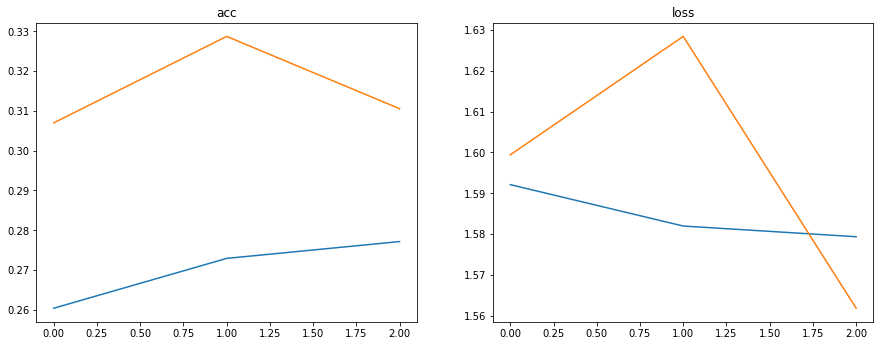

In [14]:
train_acc_list, train_loss_list = [], []
val_acc_list, val_loss_list = [], []
for epoch in range(3):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    for idx, batch in enumerate(train_iter):
        text, label = batch.text, batch.category
        optimizer.zero_grad()
        out = model(text)
        loss = loss_fn(out,label.long())
        loss.backward( retain_graph=True)
        optimizer.step()
        accracy = np.mean((torch.argmax(out,1)==label).cpu().numpy())
        # 计算每个样本的acc和loss之和
        train_acc += accracy*len(batch)
        train_loss += loss.item()*len(batch)
        
        print("\r epoch:{} loss:{}, train_acc:{}".format(epoch,loss.item(),accracy),end=" ")
        
    
    # 在验证集上预测
    with torch.no_grad():
        for idx, batch in enumerate(val_iter):
            text, label = batch.text, batch.category
            out = model(text)
            loss = loss_fn(out,label.long())
            accracy = np.mean((torch.argmax(out,1)==label).cpu().numpy())
            # 计算一个batch内每个样本的acc和loss之和
            val_acc += accracy*len(batch)
            val_loss += loss.item()*len(batch)
            
    train_acc /= len(train_iter.dataset)
    train_loss /= len(train_iter.dataset)
    val_acc /= len(val_iter.dataset)
    val_loss /= len(val_iter.dataset)
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
        
# 保存模型
torch.save(model.state_dict(), 'results/temp.pth')

# 绘制曲线
plt.figure(figsize=(15,5.5))
plt.subplot(121)
plt.plot(train_acc_list)
plt.plot(val_acc_list)
plt.title("acc")
plt.subplot(122)
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title("loss")

## 2.4 加载模型并进行预测  

在后续解题中建议使用这种方式保存和加载模型参数：创建模型实例并加载参数

In [15]:
model = Net()
model_path = "results/temp.pth"
model.load_state_dict(torch.load(model_path))
print('模型加载完成...')

模型加载完成...


给出一段文字，来预测是那位作家的风格：

In [16]:
# 这是一个片段
text = "中国中流的家庭，教孩子大抵只有两种法。其一是任其跋扈，一点也不管，\
    骂人固可，打人亦无不可，在门内或门前是暴主，是霸王，但到外面便如失了网的蜘蛛一般，\
    立刻毫无能力。其二，是终日给以冷遇或呵斥，甚于打扑，使他畏葸退缩，彷佛一个奴才，\
    一个傀儡，然而父母却美其名曰“听话”，自以为是教育的成功，待到他们外面来，则如暂出樊笼的\
    小禽，他决不会飞鸣，也不会跳跃。"

labels = {0: '鲁迅', 1: '莫言', 2: '钱钟书', 3: '王小波', 4: '张爱玲'}

# 将句子做分词，然后使用词典将词语映射到他的编号
text2idx = [TEXT.vocab.stoi[i] for i in jb.lcut(text) ]

# 转化为Torch接收的Tensor类型
text2idx = torch.Tensor(text2idx).long()

# 预测
print(labels[torch.argmax(model(text2idx.view(-1,1)),1).numpy()[0]])

莫言


我们看看片段内容应该属于作家鲁迅的风格，而预测是莫言，因此说明示范模型性能比较弱小，预测跟实际有点出入，希望大家训练一个性能比较好的模型，能够准确预测测试的各个片段。

# 3.作业
**作业内容：** 根据一段中文文本（ 100~200 个中文字符），预测这段文本的作者。  


## 3.1 创建并训练模型
深度学习模型训练流程, 包含数据处理、创建模型、训练模型、模型保存、评价模型等。  
如果对训练出来的模型不满意, 你可以通过调整模型的参数等方法重新训练模型, 直至训练出你满意的模型。  
如果你对自己训练出来的模型非常满意, 则可以提交作业!  
可以使用任意一种平台支持的框架进行模型实现。

注意：

1. 你可以在我们准好的接口中实现深度学习模型（若使用可以修改除predict外的函数接口），也可以自己实现深度学习模型或改用其他框架实现，但需要满足 predict 函数的输入输出符合格式要求！
2. 写好代码后可以在 Py 文件中使用 GPU 进行模型训练。

===========================================实现自己的深度学习模型代码答题区===========================================

双击下方区域开始编写  **数据处理**、**创建模型**、**训练模型**、**保存模型**  和  **评估模型**  等部分的代码，如果使用其他框架训练模型可以自行实现。  

In [ ]:
# 导入相关包
import copy
import os
import numpy as np
import jieba as jb
import torch
import torch.nn as nn
import torch.nn.functional as f

from torchtext import data, datasets
from torchtext.data import Field,Dataset,Iterator,Example,BucketIterator

class Net(nn.Module):
    def __init__(self,vocab_size):
        super(Net,self).__init__()
        pass

    def forward(self,x):
        """
        前向传播
        :param x: 模型输入
        :return: 模型输出
        """
        pass

def processing_data(data_path, split_ratio = 0.7):
    """
    数据处理
    :data_path：数据集路径
    :validation_split：划分为验证集的比重
    :return：train_iter,val_iter,TEXT.vocab 训练集、验证集和词典
    """
    # --------------- 已经实现好数据的读取，返回和训练集、验证集，可以根据需要自行修改函数 ------------------
    sentences = [] # 片段
    target = [] # 作者
    
    # 定义lebel到数字的映射关系
    labels = {'LX': 0, 'MY': 1, 'QZS': 2, 'WXB': 3, 'ZAL': 4}

    files = os.listdir(data_path)
    for file in files:
        if not os.path.isdir(file):
            f = open(data_path + "/" + file, 'r', encoding='UTF-8');  # 打开文件
            for index,line in enumerate(f.readlines()):
                sentences.append(line)
                target.append(labels[file[:-4]])

    mydata = list(zip(sentences, target))

    TEXT  = Field(sequential=True, tokenize=lambda x: jb.lcut(x), 
                       lower=True, use_vocab=True)
    LABEL = Field(sequential=False, use_vocab=False)

    FIELDS = [('text', TEXT), ('category', LABEL)]

    examples = list(map(lambda x: Example.fromlist(list(x), fields=FIELDS), 
                                     mydata))

    dataset = Dataset(examples, fields=FIELDS)

    TEXT.build_vocab(dataset)
    
    train, val = dataset.split(split_ratio=split_ratio)
    
    # BucketIterator可以针对文本长度产生batch，有利于训练
    train_iter, val_iter = BucketIterator.splits(
        (train,val), # 数据集
        batch_sizes=(16, 16),
        device=-1, # 如果使用gpu，此处将-1更换为GPU的编号
        sort_key=lambda x: len(x.text), 
        sort_within_batch=False,
        repeat=False # 
    )
    # --------------------------------------------------------------------------------------------
    return train_iter,val_iter,TEXT.vocab

def model(train_iter, val_iter, Text_vocab,save_model_path):
    """
    创建、训练和保存深度学习模型

    """
    # --------------------- 实现模型创建、训练和保存等部分的代码 ---------------------
    pass
    # 保存模型（请写好保存模型的路径及名称）
    
    # --------------------------------------------------------------------------------------------

def evaluate_mode(val_iter, save_model_path):
    """
    加载模型和评估模型
    可以实现，比如: 模型训练过程中的学习曲线，测试集数据的loss值、准确率及混淆矩阵等评价指标！
    主要步骤:
        1.加载模型(请填写你训练好的最佳模型),
        2.对自己训练的模型进行评估

    :param val_iter: 测试集
    :param save_model_path: 加载模型的路径和名称,请填写你认为最好的模型
    :return:
    """
    # ----------------------- 实现模型加载和评估等部分的代码 -----------------------
    pass
    
    # ---------------------------------------------------------------------------

def main():
    """
    深度学习模型训练流程,包含数据处理、创建模型、训练模型、模型保存、评价模型等。
    如果对训练出来的模型不满意,你可以通过调整模型的参数等方法重新训练模型,直至训练出你满意的模型。
    如果你对自己训练出来的模型非常满意,则可以提交作业!
    :return:
    """
    data_path = "./dataset"  # 数据集路径
    save_model_path = "results/model.pth"  # 保存模型路径和名称
    train_val_split = 0.7 #验证集比重

    # 获取数据、并进行预处理
    train_iter, val_iter,Text_vocab = processing_data(data_path, split_ratio = train_val_split)

    # 创建、训练和保存模型
    model(train_iter, val_iter, Text_vocab, save_model_path)

    # 评估模型
    evaluate_mode(val_iter, save_model_path)


if __name__ == '__main__':
    main()

## 3.2 模型预测


注意：
1. 点击左侧栏`提交作业`后点击`生成文件`则只需勾选 `predict()` 函数的cell，即【**模型预测代码答题区域**】的 cell。
2. 请导入必要的包和第三方库 (包括此文件中曾经导入过的)。
3. 请加载你认为训练最佳的模型，即请按要求填写模型路径。
4. `predict()`函数的输入和输出请**不要改动**。
5. 作业测试时记得填写你的模型路径及名称, 如果采用 [离线任务](https://momodel.cn/docs/#/zh-cn/%E5%9C%A8GPU%E6%88%96CPU%E8%B5%84%E6%BA%90%E4%B8%8A%E8%AE%AD%E7%BB%83%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0%E6%A8%A1%E5%9E%8B) 请将模型保存在 **results** 文件夹下。

In [ ]:
# ==================  提交 Notebook 训练模型结果数据处理参考示范  ==================
# 导入相关包
import copy
import os
import random
import numpy as np
import jieba as jb
import jieba.analyse
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as f
from torchtext import data
from torchtext import datasets
from torchtext.data import Field
from torchtext.data import Dataset
from torchtext.data import Iterator
from torchtext.data import Example
from torchtext.data import BucketIterator

# ------------------------------------------------------------------------------
# 本 cell 代码仅为 Notebook 训练模型结果进行平台测试代码示范
# 可以实现个人数据处理的方式，平台测试通过即可提交代码
#  -----------------------------------------------------------------------------

def load_data(path):
    """
    读取数据和标签
    :param path:数据集文件夹路径
    :return:返回读取的片段和对应的标签
    """
    sentences = [] # 片段
    target = [] # 作者

    # 定义lebel到数字的映射关系
    labels = {'LX': 0, 'MY': 1, 'QZS': 2, 'WXB': 3, 'ZAL': 4}

    files = os.listdir(path)
    for file in files:
        if not os.path.isdir(file):
            f = open(path + "/" + file, 'r', encoding='UTF-8');  # 打开文件
            for index,line in enumerate(f.readlines()):
                sentences.append(line)
                target.append(labels[file[:-4]])

    return list(zip(sentences, target))

# 定义Field
TEXT  = Field(sequential=True, tokenize=lambda x: jb.lcut(x), lower=True, use_vocab=True)
LABEL = Field(sequential=False, use_vocab=False)
FIELDS = [('text', TEXT), ('category', LABEL)]

# 读取数据，是由tuple组成的列表形式
mydata = load_data(path='dataset/')

# 使用Example构建Dataset
examples = list(map(lambda x: Example.fromlist(list(x), fields=FIELDS), mydata))
dataset = Dataset(examples, fields=FIELDS)
# 构建中文词汇表
TEXT.build_vocab(dataset)

In [ ]:
# =========================  Notebook 训练模型网络结构参考示范  =========================
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.lstm = torch.nn.LSTM(1,64)
        self.fc1 = nn.Linear(64,128)
        self.fc2 = nn.Linear(128,5)

    def forward(self,x):
        """
        前向传播
        :param x: 模型输入
        :return: 模型输出
        """
        output,hidden = self.lstm(x.unsqueeze(2).float())
        h_n = hidden[1]
        out = self.fc2(self.fc1(h_n.view(h_n.shape[1],-1)))
        return out

============================  **模型预测代码答题区域**  ============================
<br>
在下方的代码块中编写 **模型预测** 部分的代码，请勿在别的位置作答

In [ ]:
# ----------------------------- 请加载您最满意的模型 -------------------------------
# 加载模型(请加载你认为的最佳模型)
# 加载模型,加载请注意 model_path 是相对路径, 与当前文件同级。
# 如果你的模型是在 results 文件夹下的 temp.pth 模型，则 model_path = 'results/temp.pth'

# 创建模型实例
model = None
model_path = None
model.load_state_dict(torch.load(model_path))

# -------------------------请勿修改 predict 函数的输入和输出-------------------------
def predict(text):
    """
    :param text: 中文字符串
    :return: 字符串格式的作者名缩写
    """
     # ----------- 实现预测部分的代码，以下样例可代码自行删除，实现自己的处理方式 -----------
    labels = {0: 'LX', 1: 'MY', 2: 'QZS', 3: 'WXB', 4: 'ZAL'}
    # 自行实现构建词汇表、词向量等操作
    # 将句子做分词，然后使用词典将词语映射到他的编号
    text2idx = [TEXT.vocab.stoi[i] for i in jb.lcut(text) ]
    # 转化为Torch接收的Tensor类型
    text2idx = torch.Tensor(text2idx).long()
    
    # 模型预测部分
    results = model(text2idx.view(-1,1))
    prediction = labels[torch.argmax(results,1).numpy()[0]]
    # --------------------------------------------------------------------------

    return prediction

In [ ]:
sen = "我听到一声尖叫，感觉到蹄爪戳在了一个富有弹性的东西上。定睛一看，不由怒火中烧。原来，趁着我不在，隔壁那个野杂种——沂蒙山猪刁小三，正舒坦地趴在我的绣榻上睡觉。我的身体顿时痒了起来，我的目光顿时凶了起来。"
predict(sen)